In [1]:
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf
import statsmodels as stats

import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
emo = emotioncon_modelling.Modelling()
emostats = emotioncon_stats.Statistics()
prep = prep_emotioncon.PrepEmotioncon()
aux = auxiliary.Auxiliary()
attention_cr = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']
filepath = '../'
data = np.load(filepath + 'results/data_experiment.npy',allow_pickle='TRUE')
savefig = True
palette= {0: "plum", 1: "purple", 2: "lightgrey", 3: "grey"}

In [3]:
# make inputs ready
input_df = pd.read_csv(filepath + 'experiment/public/prep/videosForExperiment.csv')
inp_dummies = pd.get_dummies(input_df['category'])
inp_dummies = inp_dummies.reindex(columns=['Disgust', 'Amusement', 'Calmness', 'Anxiety', 'Sadness'])
inp = inp_dummies.values
inp = np.vstack([np.zeros(np.shape(inp)[1]), inp, np.zeros(np.shape(inp)[1]), inp])

In [4]:
data = np.load(filepath + 'results/fit_experiment.npy',allow_pickle='TRUE')
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)
Nsj = len(data)
print('N = ' + str(Nsj))

N = 108


/Users/jolandamalamud/phd/papers/git_public/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)


In [168]:
# simulate individual data from fitted kalman filter
import copy
def simulate_data(data, kf_before, kf_after, inp, mood_ratings):
    mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), \
                                   np.shape(mood_ratings)[1], np.shape(mood_ratings)[2], 2))
    T = np.shape(data[0]['ratings'])[1]
    t = 1
    inp_split = inp[t*int(T/2):t*int(T/2) + int(T/2),:]
    for sj in range(Nsj):
        for t in range(2):
            if (t==0):
                subject_kf = copy.copy(data[sj]['results_split'][kf_before])
            elif (t==1):
                subject_kf = copy.copy(data[sj]['results_split'][kf_after])
            foo, x = subject_kf.sample(int(T/2),  initial_state=data[sj]['ratings'][:,t*int(T/2)], \
                                                        control_inputs=inp_split)
            mood_ratings_split[:,:,sj,t] = x
    return mood_ratings_split
    
def plot_simulated_data_and_stats(mood_ratings_split, df, mood_categories):
    label= ['simulated mean', 'simulated variance']
    pairs = []
    for t in range(2):
        for i in mood_categories:
            pairs.append([(i, 0+t), (i, 2+t)])
            pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])

    df_stats_both = pd.DataFrame()
    for j, i in enumerate([np.nanmean(mood_ratings_split,axis=0), np.nanvar(mood_ratings_split,axis=0)]):
        df_stats, pvalues, tvalues = emostats.stats_group_difference(i, df)
        df_plot = emostats.make_df(i, df, mood_categories)
        fig, ax = plt.subplots(figsize=(20,8))
        fig, ax = emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                                 data_name=label[j] + ' ratings' , pairs=pairs, fig=fig, ax=ax, \
                                                ms=False)
        ax.set(ylabel=label[j] + ' ratings')
        df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)

    display(df_stats_both)

In [169]:
# outlier Detection (IQR)
def detect_outlier(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    ex = np.where((data >= (Q1-1.5*IQR))&(data >= (Q3+1.5*IQR)))
    print(Q1-1.5*IQR, Q3+1.5*IQR)
    return ex

def exclude_outliers(data, kf_before, kf_after):
    ee, cc = np.empty((2,Nsj)), np.empty((5,2,Nsj))
    for i in range(Nsj):
        for j, p in enumerate([kf_before, kf_after]):
            eigval,foo = np.linalg.eig(data[i]['results_split'][p].transition_matrices)
            ee[j,i] = np.sort(eigval)[-1]
            foo,cc[:,j,i],foo = np.linalg.svd(control.ctrb(data[i]['results_split'][p].transition_matrices, \
                                                      data[i]['results_split'][p].control_matrix))
    
    # exclude eigenvalues > 1
    ex = np.where(ee[:,:] > 1)[1]
    # exclude outliers in dominant singular value of controllability matrix
    ex = np.hstack((ex,detect_outlier(cc[0,:,:])[1]))
    
    ex_arr = np.zeros(len(data))  # Assuming an array size of 100, you can adjust this according to your requirements
    ex_arr[np.unique(ex)] = 1

    return ex, ex_arr == 1


/var/folders/s_/7p7b7rls6rl2gtzh2m765mdh0000gn/T/ipykernel_67466/228264459.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  ee[j,i] = np.sort(eigval)[-1]


-519.8066256074557 1263.539578100499


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,4.67,0.90,0.486,11.96,2.30,0.051
after intervention,20.47,3.93,0.003,37.34,7.17,< 0.001
change (after - before),48.17,9.26,< 0.001,18.66,3.59,0.005


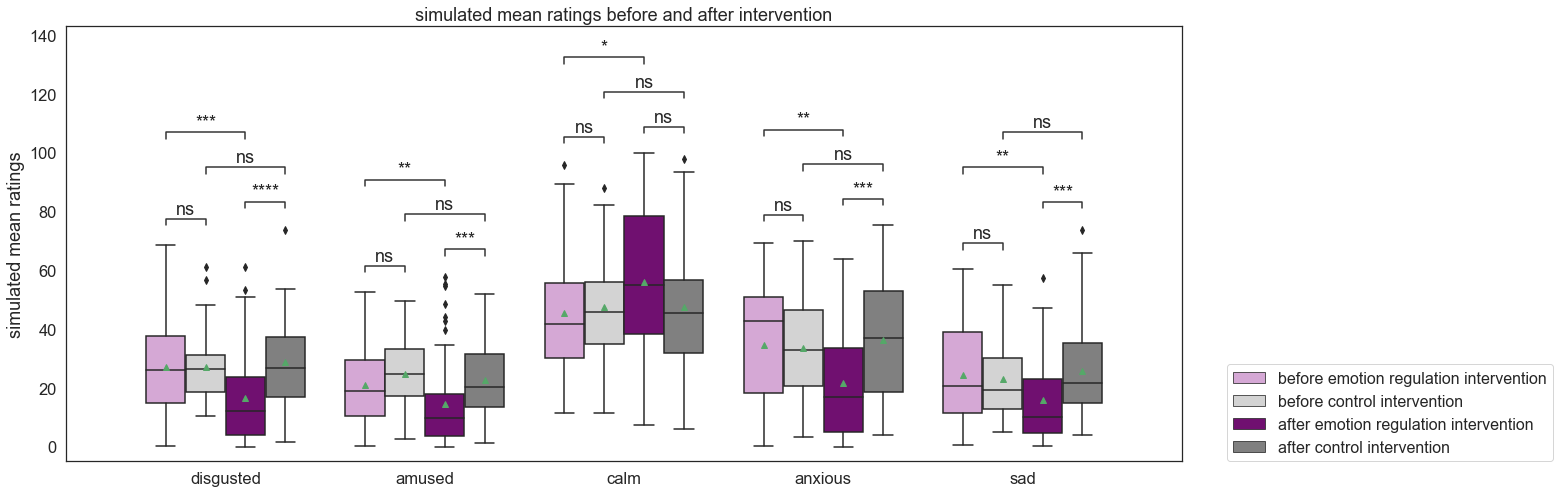

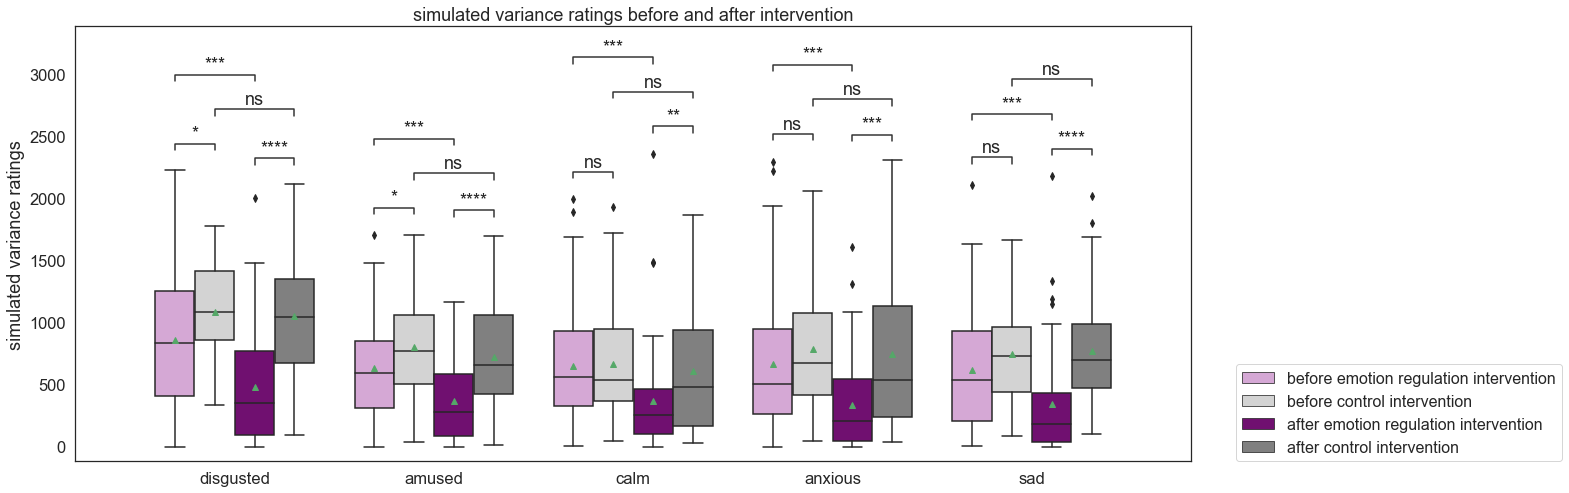

In [170]:
# simulated mean and variance difference effect due to distancing - winning model
mood_ratings_split = simulate_data(data, 13, 14, inp, mood_ratings)
foo, ex = exclude_outliers(data, 13, 14)
plot_simulated_data_and_stats(mood_ratings_split[:,:,~ex,:], df[~ex], mood_categories)

/var/folders/s_/7p7b7rls6rl2gtzh2m765mdh0000gn/T/ipykernel_67466/228264459.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  ee[j,i] = np.sort(eigval)[-1]


-69.25854634935783 364.9199911908697


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,5.37,1.03,0.407,19.90,3.81,0.004
after intervention,15.71,3.00,0.015,15.12,2.89,0.018
change (after - before),36.32,6.94,< 0.001,9.68,1.85,0.111


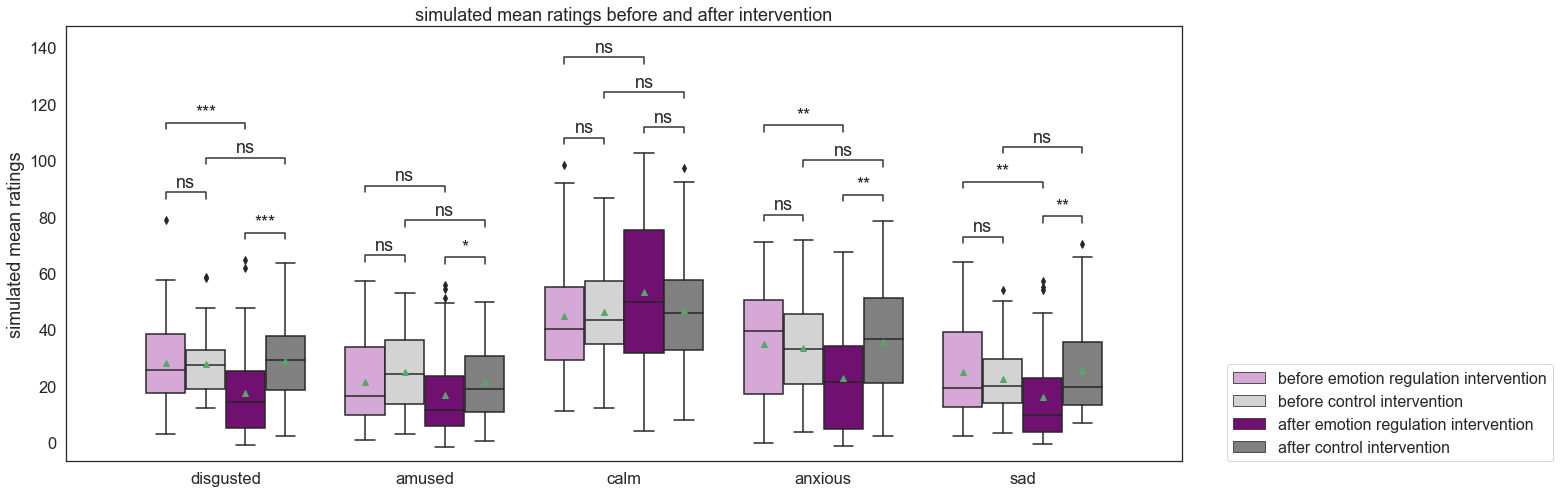

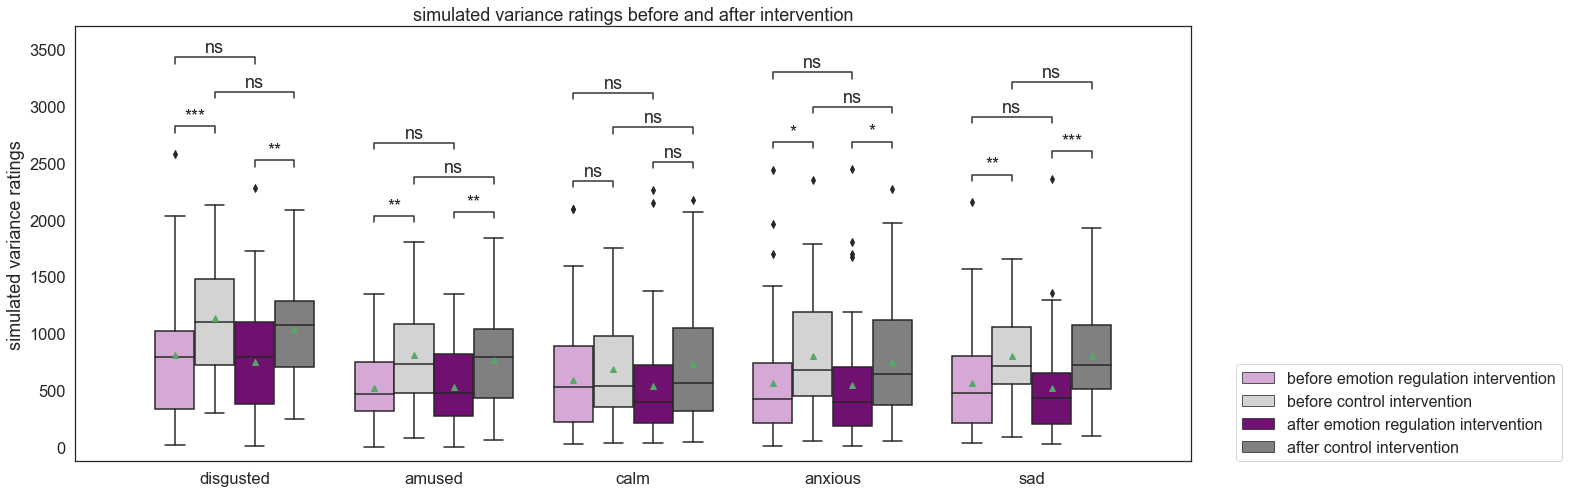

In [172]:
# simulated mean and variance difference effect due to distancing - only A can change
mood_ratings_split = simulate_data(data, 1, 2, inp, mood_ratings)
foo, ex = exclude_outliers(data, 1, 2)
plot_simulated_data_and_stats(mood_ratings_split[:,:,~ex,:], df[~ex], mood_categories)

/var/folders/s_/7p7b7rls6rl2gtzh2m765mdh0000gn/T/ipykernel_67466/228264459.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  ee[j,i] = np.sort(eigval)[-1]


-66.50950403549888 369.0837494889044


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,8.10,1.55,0.18,17.40,3.34,0.008
after intervention,18.12,3.48,0.006,22.18,4.26,0.002
change (after - before),51.47,9.88,< 0.001,28.58,5.49,< 0.001


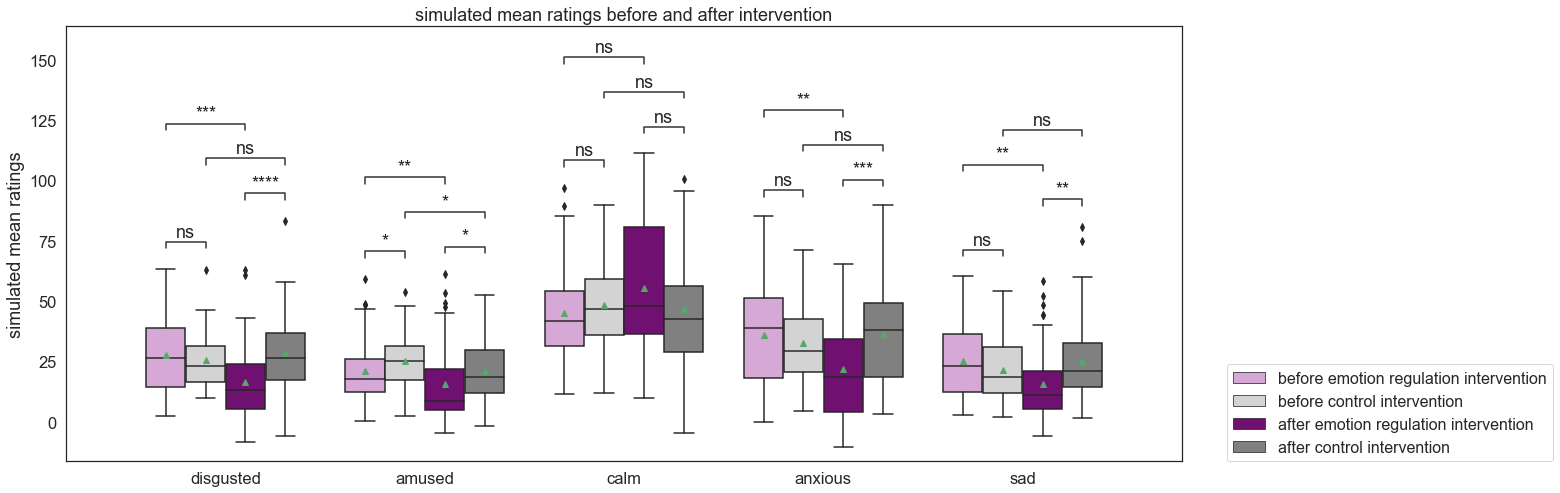

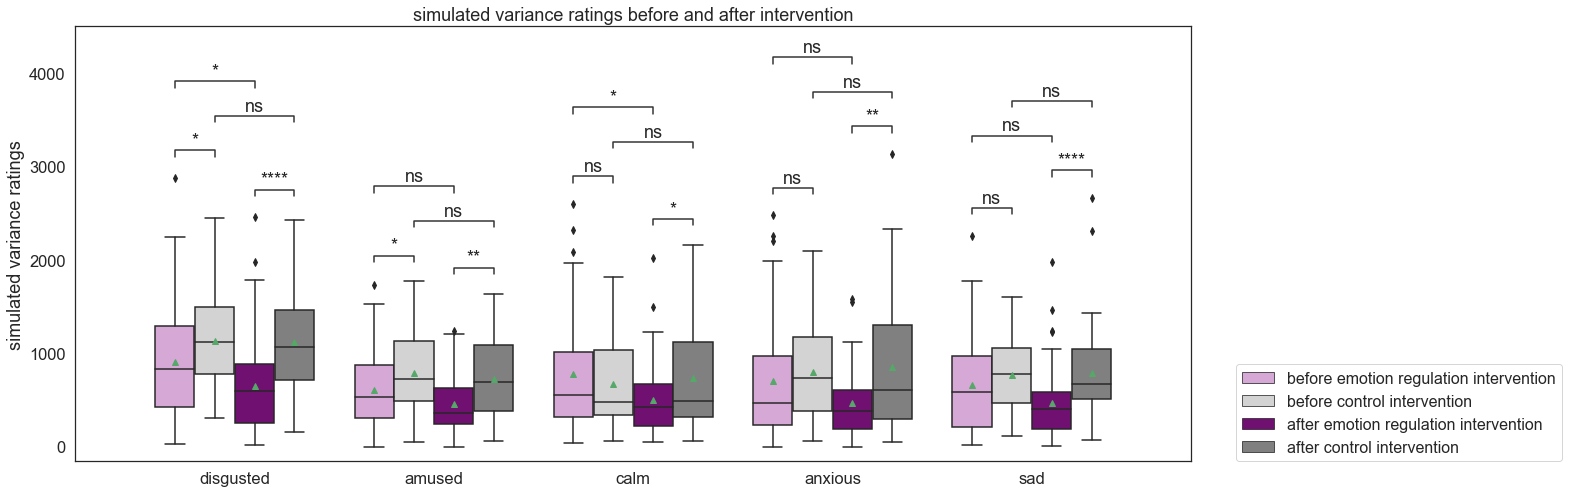

In [173]:
# simulated mean and variance difference effect due to distancing - only A can change
mood_ratings_split = simulate_data(data, 3, 4, inp, mood_ratings)
foo, ex = exclude_outliers(data, 3, 4)
plot_simulated_data_and_stats(mood_ratings_split[:,:,~ex,:], df[~ex], mood_categories)